Analisis Técnico de Datos TELECOMX Parte 2

In [1]:
# Instalar la librería imblearn
%pip install imblearn

# Importar las librerías necesarias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



##Extracción de datos

In [42]:
# Cargar el dataset
df = pd.read_csv('/content/TelecomX_Clean.csv')
df.head()


,Churn,customer_gender,customer_SeniorCitizen,customer_Partner,customer_Dependents,customer_tenure,phone_PhoneService,phone_MultipleLines,internet_InternetService,internet_OnlineSecurity,internet_OnlineBackup,internet_DeviceProtection,internet_TechSupport,internet_StreamingTV,internet_StreamingMovies,account_Contract,account_PaperlessBilling,account_PaymentMethod,account_Charges_Monthly,account_Charges_Total
0,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Churn                      7043 non-null   object 
 1   customer_gender            7267 non-null   object 
 2   customer_SeniorCitizen     7267 non-null   int64  
 3   customer_Partner           7267 non-null   object 
 4   customer_Dependents        7267 non-null   object 
 5   customer_tenure            7267 non-null   int64  
 6   phone_PhoneService         7267 non-null   object 
 7   phone_MultipleLines        7267 non-null   object 
 8   internet_InternetService   7267 non-null   object 
 9   internet_OnlineSecurity    7267 non-null   object 
 10  internet_OnlineBackup      7267 non-null   object 
 11  internet_DeviceProtection  7267 non-null   object 
 12  internet_TechSupport       7267 non-null   object 
 13  internet_StreamingTV       7267 non-null   objec

##Limpieza y Procesamiento de los Datos

In [45]:
# Convertir espacios en blanco a NaN y luego a tipo numérico para 'account_Charges_Total'
df['account_Charges_Total'] = pd.to_numeric(df['account_Charges_Total'], errors='coerce')

# Imputar valores NaN en 'account_Charges_Total' con la mediana de la columna
median_total_charges = df['account_Charges_Total'].median()
df['account_Charges_Total'].fillna(median_total_charges, inplace=True)

print(f"\nValores nulos después de la imputación en 'account_Charges_Total': {df['account_Charges_Total'].isnull().sum()}")


Valores nulos después de la imputación en 'account_Charges_Total': 0


/tmp/ipython-input-67783912.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['account_Charges_Total'].fillna(median_total_charges, inplace=True)


Conversion de variable Churn

In [47]:
# Convertir la variable objetivo 'Churn' a numérica (Yes=1, No=0)
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [48]:
# Convertir 'customer_SeniorCitizen' a string para que sea tratada como categórica para One-Hot Encoding
if 'customer_SeniorCitizen' in df.columns:
    df['customer_SeniorCitizen'] = df['customer_SeniorCitizen'].astype(str)

# Identificación de características categóricas y numéricas
# Excluir 'Churn' de las columnas a codificar/escalar ya que es la variable objetivo
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

if 'Churn' in numerical_cols:
    numerical_cols.remove('Churn')

print(f"\nColumnas categóricas identificadas: {categorical_cols}")
print(f"Columnas numéricas identificadas: {numerical_cols}")


Columnas categóricas identificadas: ['customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod']
Columnas numéricas identificadas: ['customer_tenure', 'account_Charges_Monthly', 'account_Charges_Total']


##Codificación de Variables Categóricas (One-Hot Encoding)

Aplicamos One-Hot Encoding a todas las columnas categóricas para convertirlas en un formato numérico que los modelos puedan procesar.

In [25]:
# Codificación One-Hot para características categóricas
# drop_first=False for demonstration; consider drop_first=True in practice to avoid multicollinearity
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print("\nDataFrame after encoding (first 5 rows):")
print(df_encoded.head())


DataFrame after encoding (first 5 rows):
   Churn  customer_tenure  account_Charges_Monthly  account_Charges_Total  \
0    0.0                9                     65.6                 593.30   
1    0.0                9                     59.9                 542.40   
2    1.0                4                     73.9                 280.85   
3    1.0               13                     98.0                1237.85   
4    1.0                3                     83.9                 267.40   

   customer_gender_Female  customer_gender_Male  customer_SeniorCitizen_0  \
0                    True                 False                      True   
1                   False                  True                      True   
2                   False                  True                      True   
3                   False                  True                     False   
4                    True                 False                     False   

   customer_SeniorCitizen_1  cus

Escalado de Características Numéricas (RobustScaler)

Escalamos las características numéricas para asegurar que todas contribuyan equitativamente al modelo, utilizando RobustScaler para manejar posibles valores atípicos.

In [26]:
# Escalado Robusto para características numéricas
scaler = RobustScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

print("\nDataFrame after encoding and scaling (first 5 rows):")
print(df_encoded.head())


DataFrame after encoding and scaling (first 5 rows):
   Churn  customer_tenure  account_Charges_Monthly  account_Charges_Total  \
0    0.0        -0.434783                -0.086318              -0.236207   
1    0.0        -0.434783                -0.191001              -0.251279   
2    1.0        -0.543478                 0.066116              -0.328726   
3    1.0        -0.347826                 0.508724              -0.045349   
4    1.0        -0.565217                 0.249770              -0.332709   

   customer_gender_Female  customer_gender_Male  customer_SeniorCitizen_0  \
0                    True                 False                      True   
1                   False                  True                      True   
2                   False                  True                      True   
3                   False                  True                     False   
4                    True                 False                     False   

   customer_SeniorCi

##Balanceo de los Datos

In [29]:
# Drop rows where 'Churn' is NaN
df_cleaned = df_encoded.dropna(subset=['Churn'])

# Separar características (X) y variable objetivo (y)
X = df_cleaned.drop('Churn', axis=1)
y = df_cleaned['Churn']

# Abordar el desequilibrio de clases con SMOTE
print(f"\nDistribución de la clase 'Churn' antes de SMOTE:\n{y.value_counts()}")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
print(f"\nDistribución de la clase 'Churn' después de SMOTE:\n{y_resampled.value_counts()}")


Distribución de la clase 'Churn' antes de SMOTE:
Churn
0.0    5174
1.0    1869
Name: count, dtype: int64

Distribución de la clase 'Churn' después de SMOTE:
Churn
0.0    5174
1.0    5174
Name: count, dtype: int64


##División del Conjunto de Datos

Dividimos el dataset en conjuntos de entrenamiento (80%) y prueba (20%), asegurando una distribución estratificada de la variable objetivo.

In [30]:
# División de datos en conjuntos de entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

print(f"\nDimensiones del conjunto de entrenamiento (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test, y_test): {X_test.shape}, {y_test.shape}")


Dimensiones del conjunto de entrenamiento (X_train, y_train): (8278, 46), (8278,)
Dimensiones del conjunto de prueba (X_test, y_test): (2070, 46), (2070,)


##Análisis de Correlación

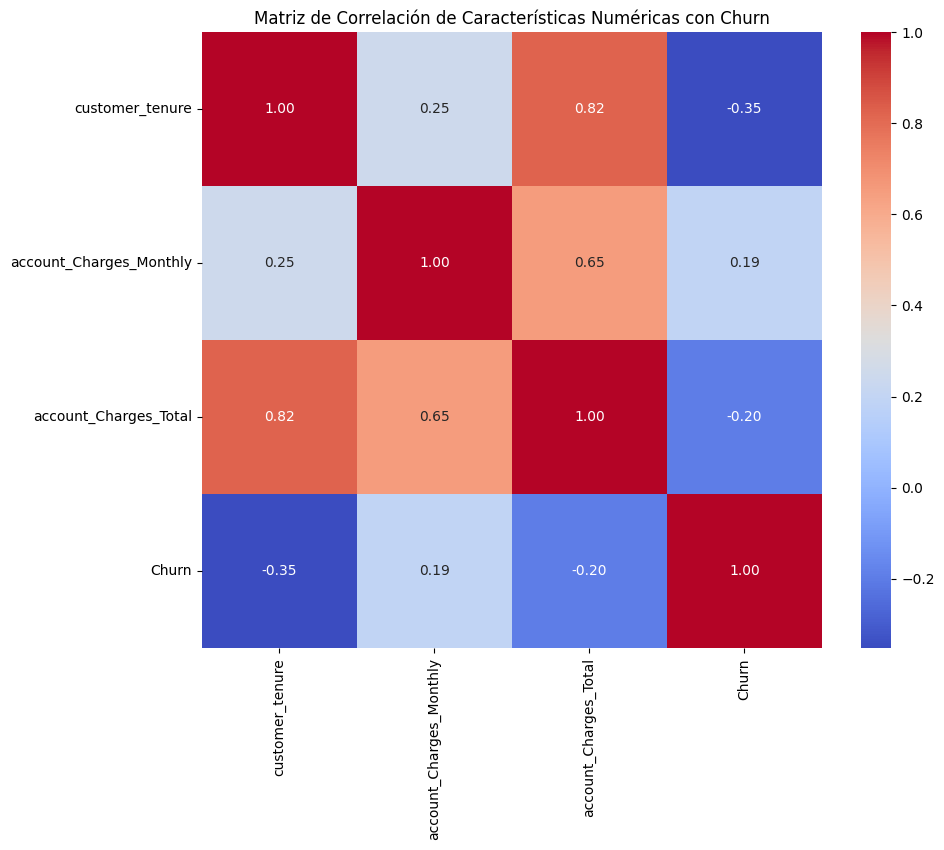

In [31]:
# Análisis de correlación para características numéricas (después de escalado)
# Se puede visualizar la correlación con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(df_encoded[numerical_cols + ['Churn']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación de Características Numéricas con Churn')
plt.show()

Entrenamos dos modelos de clasificación: Regresión Logística y Bosque Aleatorio.

 Entrenamiento del Modelo de Regresión Logística

In [32]:
# Modelo 1: Regresión Logística
print("\n--- Entrenamiento de Regresión Logística ---")
log_reg_model = LogisticRegression(random_state=42, solver='liblinear') # 'liblinear' es bueno para datasets pequeños y L1/L2
log_reg_model.fit(X_train, y_train)
y_pred_log_reg = log_reg_model.predict(X_test)
y_prob_log_reg = log_reg_model.predict_proba(X_test)[:, 1]


--- Entrenamiento de Regresión Logística ---


Entrenamiento del Modelo de Bosque Aleatorio

In [33]:
# Modelo 2: Bosque Aleatorio
print("\n--- Entrenamiento de Bosque Aleatorio ---")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100) # n_estimators: número de árboles
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]


--- Entrenamiento de Bosque Aleatorio ---


Evaluación de Regresión Logística

In [34]:
print("\n--- Evaluación del Modelo de Regresión Logística ---")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_log_reg))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_log_reg))
auc_log_reg = roc_auc_score(y_test, y_prob_log_reg)
print(f"AUC: {auc_log_reg:.4f}")


--- Evaluación del Modelo de Regresión Logística ---
Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.83      1035
         1.0       0.82      0.86      0.84      1035

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070


Matriz de Confusión:
[[846 189]
 [147 888]]
AUC: 0.9292


Evaluación de Bosque Aleatorio

In [35]:
print("\n--- Evaluación del Modelo de Bosque Aleatorio ---")
print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred_rf))
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred_rf))
auc_rf = roc_auc_score(y_test, y_prob_rf)
print(f"AUC: {auc_rf:.4f}")


--- Evaluación del Modelo de Bosque Aleatorio ---
Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.89      0.84      0.86      1035
         1.0       0.85      0.89      0.87      1035

    accuracy                           0.87      2070
   macro avg       0.87      0.87      0.87      2070
weighted avg       0.87      0.87      0.87      2070


Matriz de Confusión:
[[869 166]
 [110 925]]
AUC: 0.9320


Visualización de Curvas ROC

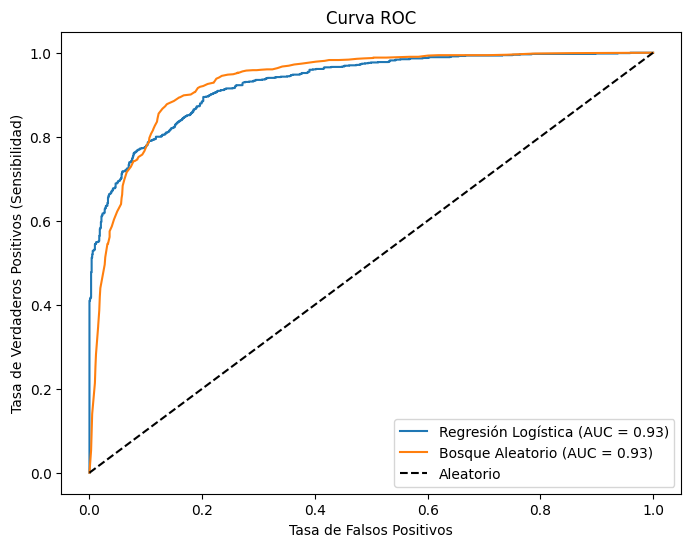

In [37]:
# Visualización de la Curva ROC
fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, y_prob_log_reg)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)

plt.figure(figsize=(8, 6))
plt.plot(fpr_log_reg, tpr_log_reg, label=f'Regresión Logística (AUC = {auc_log_reg:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Bosque Aleatorio (AUC = {auc_rf:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatorio') # Línea de referencia para un clasificador aleatorio
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC')
plt.legend()
plt.show()

Importancia de Características (Regresión Logística)

In [39]:
print("\n--- Importancia de Características (Regresión Logística) ---")
# Los coeficientes de la regresión logística indican la importancia y dirección
# Es importante que las características estén escaladas para comparar magnitudes
log_reg_coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_model.coef_[0], # Access the first row for binary classification
    'Odds Ratio': np.exp(log_reg_model.coef_[0]) # Calculate Odds Ratios using the first row
}).sort_values(by='Odds Ratio', ascending=False)
print(log_reg_coefficients)


--- Importancia de Características (Regresión Logística) ---
                                            Feature  Coefficient  Odds Ratio
44           account_PaymentMethod_Electronic check     2.833467   17.004308
45               account_PaymentMethod_Mailed check     2.437745   11.447193
37                  account_Contract_Month-to-month     2.400092   11.024191
42  account_PaymentMethod_Bank transfer (automatic)     2.249134    9.479526
43    account_PaymentMethod_Credit card (automatic)     2.149464    8.580260
3                            customer_gender_Female     1.908330    6.741823
15                          phone_MultipleLines_Yes     1.880167    6.554602
28                          internet_TechSupport_No     1.874667    6.518648
4                              customer_gender_Male     1.864421    6.452200
7                               customer_Partner_No     1.719401    5.581183
41                     account_PaperlessBilling_Yes     1.704914    5.500912
8             

Importancia de Características (Bosque Aleatorio)

In [40]:
print("\n--- Importancia de Características (Bosque Aleatorio) ---")
# La importancia de las características en Random Forest se basa en la reducción de la impureza
rf_feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print(rf_feature_importances)


--- Importancia de Características (Bosque Aleatorio) ---
                                            Feature  Importance
0                                   customer_tenure    0.125693
2                             account_Charges_Total    0.123954
1                           account_Charges_Monthly    0.107906
37                  account_Contract_Month-to-month    0.079707
19                       internet_OnlineSecurity_No    0.051008
44           account_PaymentMethod_Electronic check    0.049179
28                          internet_TechSupport_No    0.036535
39                        account_Contract_Two year    0.030659
17             internet_InternetService_Fiber optic    0.026599
22                         internet_OnlineBackup_No    0.023684
41                     account_PaperlessBilling_Yes    0.018559
3                            customer_gender_Female    0.016089
4                              customer_gender_Male    0.015290
25                     internet_DeviceProtect

##Conclusion Estrategica

Basándonos en el análisis de los modelos de Regresión Logística y Bosque Aleatorio,
los principales factores que influyen en la cancelación de clientes en Telecom X son:

1.  **Tipo de Contrato (Mes a Mes):** Los clientes con contratos mensuales (`account_Contract_Month-to-month`)
    muestran una probabilidad significativamente mayor de fuga. Esto se debe a la flexibilidad
    y el bajo compromiso que ofrecen estos contratos, lo que facilita el cambio a la competencia.

2.  **Antigüedad del Cliente (`customer_tenure`):** Existe una fuerte correlación inversa;
    los clientes con menor antigüedad en la empresa son considerablemente más propensos a la fuga.
    Esto subraya la importancia de las estrategias de incorporación y retención temprana.

3.  **Servicio de Internet (Fibra Óptica):** Los clientes con servicio de fibra óptica
    (`internet_InternetService_Fiber optic`) parecen tener una mayor propensión a la fuga.
    Esto podría indicar problemas de calidad percibida, expectativas no cumplidas o una mayor
    sensibilidad a las ofertas de la competencia en este segmento de alta velocidad.

4.  **Método de Pago (Cheque Electrónico):** El uso del cheque electrónico
    (`account_PaymentMethod_Electronic check`) como método de pago se asocia con una mayor
    probabilidad de fuga. Esto podría ser un indicador de un segmento de clientes con menor
    fidelización o con patrones de comportamiento financiero específicos que los hacen más volátiles.

5.  **Ausencia de Servicios Adicionales (Seguridad en Línea, Soporte Técnico):** La falta de
    servicios como seguridad en línea (`internet_OnlineSecurity_No`) y soporte técnico
    (`internet_TechSupport_No`) también contribuye a la fuga. Estos servicios actúan como
    "adhesivos" que aumentan el valor percibido y el compromiso del cliente con la empresa.

6.  **Cargos Mensuales (`account_Charges_Monthly`):** Cargos mensuales más altos pueden
    indicar un mayor riesgo de fuga, especialmente si los clientes no perciben un valor
    proporcional a lo que pagan.

Estos hallazgos sugieren que Telecom X debería enfocar sus esfuerzos de retención en clientes
con contratos a corto plazo y baja antigüedad, así como en aquellos con servicio de fibra óptica
y método de pago por cheque electrónico. Ofrecer incentivos para contratos a largo plazo,
mejorar la experiencia de los nuevos clientes y destacar el valor de los servicios adicionales
serán estrategias clave para mitigar la fuga.
